# Implementation of denosing autoencoders on MNIST data-set
# Assignment 1 - Alessio Cascione

### Section 1 - Autoencoder implementation



We present here an implementation of a basic one layer linear autoencoder along with its multi-layers deep version: a method for layerwise pretraining is also introduced for the deep linear autoencoder case. Furthermore, a specific class implementing convolutional autoencoders (one-layer and multi-layers ones) is also presented and a comparison with standard linear autoencoder is shown. The convolutional autoencoders are kept really simple, using Max pooling with kernel and stride = (2,2). An intermediate linear layer between encoder and decoder is also introduce to reduce dimensionality.

For each kind of model, an hold-out validation approach for hyper-parameters selection has been performed. Visualizations and comparisons are made among the best resulting models coming out from this simple model selection phase. We avoid to report model selection outputs to ease the reading.

For performing model comparison, we used the simple MSE loss resulting from directly comparing the reconstructed images with the input along with accuracy classification results obtained by the same simple softmax dense layer implemented in Keras trained over each autoencoders' encoders output.

The same hyperparameters have been chosen for comparing denoising and standard autoencoders, in order to evaluate the difference. The comparison is focused on different classification accuracy scores obtained through the simple dense layer used in a supervised context.

#### AE implementation

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *

import torch
import torch.nn.functional as F
import torch.nn.modules.loss as loss
from torch.utils.data import Dataset
from torch.nn.modules import padding
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn


from copy import deepcopy
from sklearn.model_selection import ParameterGrid

import math
import numpy as np
from matplotlib import pyplot as plt
from abc import abstractmethod

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class GeneralAE(nn.Module):
  @abstractmethod
  def __init__(self):
        super().__init__()
        self.encoder = None
        self.decoder = None

  def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

  def fit(self, train_set, val_set = None, epochs=5, lr=0.1, momentum=0.1 , batch_size=16,
          early_stopping = True , criterion = nn.MSELoss()):

    if early_stopping and val_set == None:
      raise TypeError('A validation set should be defined with early stopping strategy')

    self.to(device)

    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    print('Fitting on a ' + str(len(train_set)) + ' long data-set' )

    optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=momentum)
    criterion = criterion

    torch.cuda.empty_cache()

    training_loss = {'training_loss' : []}
    validation_loss = {'validation_loss' : []}
    loss = None

    for epoch in range(epochs):
          self.train()
          tr_loss = 0
          n_batches = 0
          for index, data in enumerate(train_dataloader):
            #targets are simply the original image (no noise applied in the denoising case)
            #as defined in modified FastMNIST subclass implementation
            #this allows for a cleaner version of the code that is the same for basic and denoising cases

            optimizer.zero_grad()
            instances, targets = data[0].to(device), data[1].to(device)

            output = self(instances)

            output, targets = torch.flatten(output, 1), torch.flatten(targets, 1)

            loss = criterion(output, targets)
            tr_loss += loss.item()

            loss.backward()
            optimizer.step()

            n_batches += 1

          training_loss['training_loss'].append(tr_loss / n_batches)

          if val_set != None:
            val_loss = self.evaluate(test_set = val_set, criterion = criterion)
            validation_loss['validation_loss'].append(val_loss)
            torch.cuda.empty_cache()

          #introducing very simple early stopping approach
          if early_stopping and epoch > 5:
            validation_scores = validation_loss['validation_loss'][-5:]
            if (abs(validation_scores[-5] - validation_scores[-1])) <= 3e-05:
              return training_loss, validation_loss

    return training_loss, validation_loss


  def evaluate(self, test_set, batch_size = None, criterion = nn.MSELoss()):

    batch_size = len(test_set) if batch_size == None else batch_size

    self.to(device)
    self.eval()

    with torch.no_grad():
      test_loss = 0
      n_batches = 0
      test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)
      for index, data in enumerate(test_dataloader):

            instances, targets = data[0].to(device), data[1].to(device)
            output = self(instances)
            output, targets = torch.flatten(output, 1), torch.flatten(targets, 1)
            loss = criterion(output, targets)

            test_loss += loss.item()
            n_batches +=1


    return test_loss / n_batches


  def interpolation(self, x1, x2, a = 0.1):

    with torch.no_grad():
      z1 = self.encoder(x1.to(device))
      z2 = self.encoder(x2.to(device))
      z1_ = z1*a
      z2_ = z2*(1-a)

      interpolated_img = z1_ + z2_
      interpolated_decoded = self.decoder(interpolated_img.to(device))

      z1 = self.decoder(z1.to(device))
      z2 = self.decoder(z2.to(device))

    return z1, z2, interpolated_decoded


  def test_classifier(self, train_dataset, test_dataset, train_labels, test_labels, num_classes = 10, batch_size = 64, epochs = 10):
    with torch.no_grad():
      train_set = self.encoder(train_dataset).cpu().detach().numpy()
      test_set= self.encoder(test_dataset).cpu().detach().numpy()

    train_labels = to_categorical(np.array(train_labels.cpu()), num_classes= num_classes)
    test_labels = to_categorical(np.array(test_labels.cpu()), num_classes= num_classes)

    clf = tf.keras.Sequential([Dense(input_dim=test_set.shape[-1], units= num_classes, activation='softmax')])
    clf.compile(optimizer='sgd', loss='categorical_crossentropy', metrics='accuracy')
    clf.fit(x=train_set, y=train_labels, batch_size= batch_size, epochs = epochs, verbose=0)

    return clf.evaluate(x=test_set, y=test_labels, batch_size=len(test_set))




In [ ]:
class LinearNaiveAutoencoder(GeneralAE):
  def __init__(self, input_dimensions = 784, latent_dimensions = 200, bias=True):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dimensions, latent_dimensions, bias=bias),
            nn.ReLU(inplace=True)
            )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dimensions, input_dimensions, bias=bias),
            nn.Sigmoid()
            )


class LinearDeepAutoencoder(GeneralAE):
  def __init__(self, layers_dimensions, bias = True):
    super().__init__()
    self.bias = bias

    encoder_layers = []
    decoder_layers = []

    for i in range(len(layers_dimensions) - 1):
      encoder_layers.append(nn.Linear(layers_dimensions[i], layers_dimensions[i + 1], bias=bias))
      encoder_layers.append(nn.ReLU(inplace=True))
    for i in reversed(range(1, len(layers_dimensions))):
      decoder_layers.append(nn.Linear(layers_dimensions[i], layers_dimensions[i - 1], bias=bias))
      decoder_layers.append(nn.ReLU(inplace=True))

    decoder_layers[-1] = nn.Sigmoid()

    self.encoder = nn.Sequential(nn.Flatten(), *encoder_layers)
    self.decoder = nn.Sequential(*decoder_layers)



  def pre_train_layers(self, train_set, val_set = None, epochs = 5, batch_size = 16, lr = 0.1, momentum = 0.0, criterion = nn.MSELoss(), early_stopping = False):

    curr_train_set = train_set
    curr_val_set = val_set

    for i, layer in enumerate(self.encoder):
      if isinstance(layer, nn.Linear):

        layer_ae = LinearNaiveAutoencoder(layer.in_features, layer.out_features, bias=self.bias)
        layer_ae.fit(train_set=curr_train_set, val_set = curr_val_set,  epochs=epochs, lr=lr, momentum=momentum , batch_size=batch_size, criterion = criterion, early_stopping = early_stopping)


        self.encoder[i].weight = nn.Parameter(layer_ae.encoder[1].weight)
        self.decoder[len(self.decoder) - i - 1].weight = nn.Parameter(layer_ae.decoder[0].weight)

        if self.bias:
          self.encoder[i].bias = nn.Parameter(layer_ae.encoder[1].bias)
          self.decoder[len(self.decoder) - i - 1].bias = nn.Parameter(layer_ae.decoder[0].bias)

        with torch.no_grad():
          curr_train_set = torch.unsqueeze(torch.sigmoid(layer_ae.encoder(curr_train_set.data)),1)
          curr_val_set = torch.unsqueeze(torch.sigmoid(layer_ae.encoder(curr_val_set.data)),1) if curr_val_set != None else None

        if epochs > 20:
          epochs = epochs // 2


In [ ]:
class ConvolutionalNaiveAutoencoder(GeneralAE):
    def __init__(self, channels=1, filters=16, kernel_size = 3, linear_layer_dimension=50, img_size = (28,28)):

        super().__init__()

        central_length = math.floor(img_size[0] / 2)
        pad = (kernel_size - 1) // 2

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=filters, kernel_size=kernel_size, stride=1, padding=pad),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=central_length ** 2 * filters, out_features=linear_layer_dimension),
            nn.ReLU(inplace=True)
            )

        # set kernel size, padding and stride to get the correct output shape

        if (2 * central_length) == img_size[0]:
          kernel_size = 2
        else:
          kernel_size = 3


        self.decoder = nn.Sequential(
            nn.Linear(in_features=linear_layer_dimension, out_features=central_length ** 2 * filters),
            nn.ReLU(inplace=True),
            nn.Unflatten(dim=1, unflattened_size=(filters, central_length, central_length)),
            nn.ConvTranspose2d(in_channels=filters, out_channels=channels, kernel_size=kernel_size, stride=2, padding=0),
            nn.Sigmoid()
            )



In [ ]:
class ConvolutionalDeepAutoencoder(GeneralAE):
    def __init__(self, layers_dimensions = [3, 6], kernels = [3,3],
                 img_size = (28,28), final_linear_dimension = 50, pooling=True):
      super().__init__()
      assert len(layers_dimensions) == len(kernels)

      layers_dimensions = [1] + layers_dimensions
      side_len = img_size[0]
      side_lengths = [side_len]

      encoder_layers = []
      decoder_layers = []


      for i in range(len(layers_dimensions) - 1):
         pad = (kernels[i] - 1) // 2

         encoder_layers.append(nn.Conv2d(in_channels=layers_dimensions[i], out_channels=layers_dimensions[i + 1], kernel_size=kernels[i],
                                        padding=pad, stride=1))
         encoder_layers.append(nn.ReLU(inplace=True))

         if pooling and (i == 0 or i == 2) and side_len > 3:
          encoder_layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
          side_len = math.floor(side_len / 2)
          side_lengths.append(side_len)


      linear_layer_central_dim = side_len ** 2 * layers_dimensions[-1]


      self.encoder = nn.Sequential(
          *encoder_layers,
          nn.Flatten(),
          nn.Linear(linear_layer_central_dim, linear_layer_central_dim // 2),
          nn.ReLU(inplace = True),
          nn.Linear(linear_layer_central_dim // 2, final_linear_dimension),
          nn.ReLU(inplace = True)
      )

      central_side_len = side_lengths.pop(-1)

      for i in reversed(range(1, len(layers_dimensions))):
        #set kernel_size for decoder_layers

        if len(side_lengths) > 0 and side_len * 2 == side_lengths.pop(-1):
          kernel_size = 2
        else:
          kernel_size = 3


        #set padding size for decoder_layers
        if side_len == img_size[0]:
          pad, stride = 1, 1
        else:
          pad, stride = 0, 2

        decoder_layers.append(nn.ConvTranspose2d(in_channels=layers_dimensions[i], out_channels=layers_dimensions[i - 1], kernel_size=kernel_size,
                                                 padding=pad, stride=stride))
        decoder_layers.append(nn.ReLU(inplace = True))

        if pad != 1:
          if kernel_size == 2:
            side_len = side_len * 2
          else:
            side_len = (side_len * 2) + 1

      decoder_layers[-1] = nn.Sigmoid()


      self.decoder = nn.Sequential(
            nn.Linear(final_linear_dimension, linear_layer_central_dim // 2),
            nn.ReLU(inplace=True),
            nn.Linear(linear_layer_central_dim // 2, linear_layer_central_dim),
            nn.ReLU(inplace=True),
            nn.Unflatten(dim=1, unflattened_size=(layers_dimensions[-1], central_side_len, central_side_len)),
            *decoder_layers,
        )


#### MNIST data-set preparation

A sub-class of torchvision's MNIST data-set is introduced, including an additional method in order to add noise on the data-set so that training a denoising AE is possible.

In [ ]:
from torchvision.datasets import MNIST

class FastMNIST(MNIST):
  # FastMNIST subclass is considered with some modifications for assignment purposes

  #https://github.com/y0ast/pytorch-snippets/tree/main/fast_mnist is the subclass source

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Scale data to [0,1]
        self.data = self.data.unsqueeze(1).float().div(255)

        # Normalize it with the usual MNIST mean and std
        self.data = self.data.sub_(0.1307).div_(0.3081)

        #Since we aim at minimizing the difference between the input and its reconstruction
        #we can assign to the targets the actual data.

        self.classes = deepcopy(self.targets)
        self.targets = deepcopy(self.data)

        # Put data, targets and classes on GPU if available
        self.data, self.targets, self.classes = self.data.to(device), self.targets.to(device), self.classes.to(device)


    def apply_noise(self, noise_factor = 0.1):
      #use this method to apply noise on MNIST data

      self.data = (self.data) + (noise_factor * torch.randn(self.data.shape).to(device))
      self.data = self.data - torch.min(self.data)
      self.data = self.data / torch.max(self.data)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        return img, target


In [ ]:
def get_validation(FastMNIST_train, seed = 42, val_size = 10000):
  #split MNIST training set to obtain validation set


  FastMNIST_training = deepcopy(FastMNIST_train)
  FastMNIST_validation = deepcopy(FastMNIST_train)

  g = torch.Generator()
  g.manual_seed(seed)
  perm = torch.randperm(FastMNIST_training.data.size()[0], generator = g)

  #permute data indexes

  FastMNIST_training.data = FastMNIST_training.data[perm]
  FastMNIST_training.targets = FastMNIST_training.targets[perm]
  FastMNIST_training.classes = FastMNIST_training.classes[perm]

  #get validation set

  FastMNIST_validation.data = FastMNIST_training.data[0: val_size]
  FastMNIST_validation.targets = FastMNIST_training.targets[0: val_size]
  FastMNIST_validation.classes = FastMNIST_training.classes[0: val_size]

  #get re-sized training set

  FastMNIST_training.data = FastMNIST_training.data[val_size :]
  FastMNIST_training.targets = FastMNIST_training.targets[val_size :]
  FastMNIST_training.classes = FastMNIST_training.classes[val_size :]

  return FastMNIST_training, FastMNIST_validation


The following  functions have been used in order to perform a simple hold-out model selection. We avoid to report the actual model selection results in order to have a cleaner visualization of the workflow.

All models' hyperparameters used for the next training and pre-training steps have been selected in this way. We must specify that the hyperparameter tuning was only superficial and far from a complete search in terms of hyperaprameter values and architectures, not being the main core objective of the assignment.

In [ ]:
def selection_linear_ae(params_list, X_train_val, X_test_val, model_kind = 'simple' , seed = 0, es_val_size = 5000, pre_train = False, fine_tune = False):

  rank_models = {}

  for params in params_list:
    #obtain the same validation set from the starting training set for early stopping purposes for all the models

    X_early_stopping_train, X_early_stopping_val = get_validation(X_train_val, seed = seed, val_size = es_val_size)

    epochs =  params['epochs']
    lr = params['lr']
    momentum = params['momentum']
    batch_size = params['batch_size']

    if model_kind == 'deep':

      layers_dimensions = params['layers_dimensions']
      model = LinearDeepAutoencoder(layers_dimensions = layers_dimensions)

      if fine_tune and pre_train:

        model.pre_train_layers(train_set = X_early_stopping_train, val_set = X_early_stopping_val,
                               epochs = 40, batch_size = 16, lr = 0.1, momentum = 0.0, criterion = nn.MSELoss())

        model.fit(train_set = X_early_stopping_train, val_set = X_early_stopping_val,
              epochs = epochs, lr = lr, momentum = momentum, batch_size = batch_size)

      if pre_train and not(fine_tune):

        model.pre_train_layers(train_set = X_early_stopping_train, val_set = X_early_stopping_val,
                               epochs = epochs, batch_size = batch_size, lr = lr, momentum = momentum, criterion = nn.MSELoss())

    if model_kind == 'simple':
      latent_dimensions = params['latent_dimensions']

      model = LinearNaiveAutoencoder(latent_dimensions = latent_dimensions)
      model.fit(train_set = X_early_stopping_train, val_set = X_early_stopping_val, epochs = epochs, lr = lr, momentum = momentum, batch_size = batch_size)



    loss_result = model.evaluate(test_set = X_test_val)
    clf_accuracy = model.test_classifier(train_dataset = X_train_val.data , test_dataset = X_test_val.data ,
                                         train_labels = X_train_val.classes, test_labels = X_test_val.classes)[1]


    rank_models[(loss_result, clf_accuracy)] = params

  return rank_models

In [ ]:
def selection_convolutional_ae(params_list, X_train_val, X_test_val, model_kind = 'simple' , seed = 0, es_val_size = 5000, pre_train = False, fine_tune = False):

  rank_models = {}

  for params in params_list:
    #obtain the same validation set from the starting training set for early stopping purposes for all the models

    X_early_stopping_train, X_early_stopping_val = get_validation(X_train_val, seed = seed, val_size = es_val_size)

    epochs =  params['epochs']
    lr = params['lr']
    momentum = params['momentum']
    batch_size = params['batch_size']

    if model_kind == 'simple':

       channels = params['channels']
       filters = params['filters']
       kernel_size = params['kernel_size']
       linear_layer_dimension = params['linear_layer_dimension']
       img_size = params['img_size']

       model = ConvolutionalNaiveAutoencoder(channels = channels, filters = filters, kernel_size = kernel_size,
                                            linear_layer_dimension = linear_layer_dimension, img_size = img_size )

    if model_kind == 'deep':
      layers_dimensions = params['layers_dimensions']
      kernels = params['kernels']
      final_linear_dimension = params['final_linear_dimension']
      img_size = params['img_size']
      pooling = params['pooling']


      model = ConvolutionalDeepAutoencoder(layers_dimensions = layers_dimensions, kernels = kernels,
                                           img_size = img_size, final_linear_dimension = final_linear_dimension, pooling=pooling)



    model.fit(train_set = X_early_stopping_train, val_set = X_early_stopping_val,
              epochs = epochs, lr = lr, momentum = momentum, batch_size = batch_size)


    loss_result = model.evaluate(test_set = X_test_val)
    clf_accuracy = model.test_classifier(train_dataset = X_train_val.data , test_dataset = X_test_val.data ,
                                         train_labels = X_train_val.classes, test_labels = X_test_val.classes)[1]


    rank_models[(loss_result, clf_accuracy)] = params

  return rank_models

### Basic case training and evaluation


We train different kinds of autoencoders on the simple non-denoising case: it is possible to notice how simple pre-training of a deep linear autoencoder is insufficient to allow good performances alone, having even a basic linear autoencoder highly outperforming the simple layer-wise pre-training case.

Performing further training of all layers allow for better performance (0.8017 accuracy). The simple linear autoencoder needs the highest number of epochs to reach just about 0.8629 of accuracy.

Reasonably, the best results are obtained using either a simple one layer convolutional architecture (0.9040 accuracy) or a multi-layer one (0.9246 accuracy), both architectures needing far less epochs in order to reach satisfactory results.


#### Basic Linear Naive Autoencoder results

In [ ]:
#Best result LinearNaiveAutoencoder
train_dataset_full = FastMNIST('data/MNIST', train=True, download=True)
test_dataset = FastMNIST('data/MNIST', train=False, download=True)


X_train, X_val_early_stopping = get_validation(train_dataset_full, seed = 1, val_size = 6000)

naive_linear = LinearNaiveAutoencoder(latent_dimensions = 200)

training_loss_history, validation_loss_history = naive_linear.fit(train_set = X_train, val_set = X_val_early_stopping, epochs = 500, lr = 0.3, momentum = 0.1, batch_size = 32, early_stopping = True)
final_epoch_num = len(validation_loss_history['validation_loss'])
last_tr_loss, last_vl_loss = training_loss_history['training_loss'][-1], validation_loss_history['validation_loss'][-1]

print('The model has been trained for a total {} epochs, the last one having as training loss {} and validaton loss {}'.format(final_epoch_num, last_tr_loss, last_vl_loss))

test_result = naive_linear.evaluate(test_set = test_dataset)
accuracy = naive_linear.test_classifier(train_dataset = train_dataset_full.data, test_dataset = test_dataset.data ,
                                         train_labels = train_dataset_full.classes, test_labels = test_dataset.classes)[1]

print('Test set loss: {}'.format(test_result))
print('Classification accuracy: {}'.format(accuracy))


100%|██████████| 9912422/9912422 [00:00<00:00, 101818899.53it/s]


Extracting data/MNIST/FastMNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/FastMNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35440518.97it/s]


Extracting data/MNIST/FastMNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/FastMNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26238898.36it/s]


Extracting data/MNIST/FastMNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/FastMNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20074319.04it/s]


Extracting data/MNIST/FastMNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/FastMNIST/raw

Fitting on a 54000 long data-set
The model has been trained for a total 210 epochs, the last one having as training loss 0.4838311064511679 and validaton loss 0.48442018032073975
1/1 [==============================] - 0s 209ms/step - loss: 1.4049 - accuracy: 0.8629
Test set loss: 0.48978933691978455
Classification accuracy: 0.8629000186920166


#### Basic Linear Deep autoencoder with layers pre-train

In [ ]:
#Best result LinearDeep Pre-training
train_dataset_full = FastMNIST('data/MNIST', train=True, download=True)
test_dataset = FastMNIST('data/MNIST', train=False, download=True)

X_train, X_val_early_stopping = get_validation(train_dataset_full, seed = 1, val_size = 6000)

deep_linear = LinearDeepAutoencoder(layers_dimensions = [784,200,100])
deep_linear.pre_train_layers(train_set = X_train, val_set = X_val_early_stopping, epochs = 40, lr = 0.1, momentum = 0.1, batch_size = 16, early_stopping = True)


test_result = deep_linear.evaluate(test_set = test_dataset)
accuracy = deep_linear.test_classifier(train_dataset = train_dataset_full.data, test_dataset = test_dataset.data ,
                                         train_labels = train_dataset_full.classes, test_labels = test_dataset.classes)[1]

print('Test set loss: {}'.format(test_result))
print('Classification accuracy: {}'.format(accuracy))


Fitting on a 54000 long data-set
Fitting on a 54000 long data-set
1/1 [==============================] - 0s 135ms/step - loss: 10.7652 - accuracy: 0.6191
Test set loss: 0.998552680015564
Classification accuracy: 0.6190999746322632


#### Basic Linear Deep autoencoder with pre-train and fine-tuning

In [ ]:
#Best result LinearDeep Pre-training + fine_tune
train_dataset_full = FastMNIST('data/MNIST', train=True, download=True)
test_dataset = FastMNIST('data/MNIST', train=False, download=True)

X_train, X_val_early_stopping = get_validation(train_dataset_full, seed = 1, val_size = 6000)

deep_linear = LinearDeepAutoencoder(layers_dimensions = [784,200,100])
deep_linear.pre_train_layers(train_set = X_train, val_set = X_val_early_stopping, epochs = 40, lr = 0.1, momentum = 0.1, batch_size = 16, early_stopping = True)

training_loss_history, validation_loss_history = deep_linear.fit(train_set = X_train, val_set = X_val_early_stopping, epochs = 500, lr = 0.1, momentum = 0.1, batch_size = 16, early_stopping = True)
final_epoch_num = len(validation_loss_history['validation_loss'])
last_tr_loss, last_vl_loss = training_loss_history['training_loss'][-1], validation_loss_history['validation_loss'][-1]


print('The model has been trained for a total {} epochs, the last one having as training loss {} and validaton loss {}'.format(final_epoch_num, last_tr_loss, last_vl_loss))


test_result = deep_linear.evaluate(test_set = test_dataset)
accuracy = deep_linear.test_classifier(train_dataset = train_dataset_full.data, test_dataset = test_dataset.data ,
                                         train_labels = train_dataset_full.classes, test_labels = test_dataset.classes)[1]

print('Test set loss: {}'.format(test_result))
print('Classification accuracy: {}'.format(accuracy))


Fitting on a 54000 long data-set
Fitting on a 54000 long data-set
Fitting on a 54000 long data-set
The model has been trained for a total 53 epochs, the last one having as training loss 0.4916338833084813 and validaton loss 0.49257558584213257
1/1 [==============================] - 0s 140ms/step - loss: 2.1962 - accuracy: 0.8017
Test set loss: 0.497297078371048
Classification accuracy: 0.8016999959945679


#### Basic Simple Convolutional Autoencoder

In [ ]:
X_train, X_val_early_stopping = get_validation(train_dataset_full, seed = 1, val_size = 6000)

simple_conv_ae = ConvolutionalNaiveAutoencoder(channels = 1, filters = 5, kernel_size = 3,
                                            linear_layer_dimension = 200, img_size = (28,28))


training_loss_history, validation_loss_history = simple_conv_ae.fit(train_set = X_train, val_set = X_val_early_stopping, epochs = 100, lr = 0.1, momentum = 0.1, batch_size = 16, early_stopping = True)
final_epoch_num = len(validation_loss_history['validation_loss'])
last_tr_loss, last_vl_loss = training_loss_history['training_loss'][-1], validation_loss_history['validation_loss'][-1]

print('The model has been trained for a total {} epochs, the last one having as training loss {} and validaton loss {}'.format(final_epoch_num, last_tr_loss, last_vl_loss))

test_result = simple_conv_ae.evaluate(test_set = test_dataset)
accuracy = simple_conv_ae.test_classifier(train_dataset = train_dataset_full.data, test_dataset = test_dataset.data ,
                                         train_labels = train_dataset_full.classes, test_labels = test_dataset.classes)[1]



Fitting on a 54000 long data-set
The model has been trained for a total 99 epochs, the last one having as training loss 0.48598040054462577 and validaton loss 0.4871944189071655
1/1 [==============================] - 0s 461ms/step - loss: 0.7378 - accuracy: 0.9040


#### Basic Deep Convolutional Autoencoder

In [ ]:
#train_dataset_full.apply_noise()

X_train, X_val_early_stopping = get_validation(train_dataset_full, seed = 1, val_size = 6000)

deep_conv_ae = ConvolutionalDeepAutoencoder(layers_dimensions = [3,10], kernels = [3,5], img_size = (28,28), final_linear_dimension = 300, pooling=False)

training_loss_history, validation_loss_history = deep_conv_ae.fit(train_set = X_train, val_set = X_val_early_stopping, epochs = 20, lr = 0.1, momentum = 0.0, batch_size = 16, early_stopping = True)
final_epoch_num = len(validation_loss_history['validation_loss'])
last_tr_loss, last_vl_loss = training_loss_history['training_loss'][-1], validation_loss_history['validation_loss'][-1]


Fitting on a 54000 long data-set


In [ ]:
print('The model has been trained for a total {} epochs, the last one having as training loss {} and validaton loss {}'.format(final_epoch_num, last_tr_loss, last_vl_loss))

test_result = deep_conv_ae.evaluate(test_set = test_dataset)
accuracy = deep_conv_ae.test_classifier(train_dataset = train_dataset_full.data, test_dataset = test_dataset.data ,
                                         train_labels = train_dataset_full.classes, test_labels = test_dataset.classes)[1]

The model has been trained for a total 20 epochs, the last one having as training loss 0.4713861291850055 and validaton loss 0.4728398323059082
1/1 [==============================] - 0s 157ms/step - loss: 0.4575 - accuracy: 0.9246


### Denoising Case training and evaluation

For the denoising case, we apply random noise training the same kind of architectures as before. Similar comments regarding pre-training of a linear deep autoencoder apply here (performing a further complete training step after layer-wise pretraining allows to get performance going from 0.5512 accuracy to 0.6816).

Also in this case the best results are obtained using convolutions, with 90% of accuracy in the deep convolutional case. The other non-convolutional architectures gave rise to unsatisfactory results, but the performances could depend on the superifical model selection previously done. In any case, we will keep the deep convolutional AE results as a reference for interpolation analysis, given the satisfactory result in the denoising context.

#### Denoising Simple Linear Autoencoder

In [ ]:
train_dataset_full = FastMNIST('data/MNIST', train=True, download=True)
train_dataset_full.apply_noise()

X_train, X_val_early_stopping = get_validation(train_dataset_full, seed = 42, val_size = 6000)


naive_linear = LinearNaiveAutoencoder(latent_dimensions = 200)

training_loss_history, validation_loss_history = naive_linear.fit(train_set = X_train, val_set = X_val_early_stopping, epochs = 500, lr = 0.3, momentum = 0.1, batch_size = 32, early_stopping = True)
final_epoch_num = len(validation_loss_history['validation_loss'])
last_tr_loss, last_vl_loss = training_loss_history['training_loss'][-1], validation_loss_history['validation_loss'][-1]

In [ ]:
print('The model has been trained for a total {} epochs, the last one having as training loss {} and validaton loss {}'.format(final_epoch_num, last_tr_loss, last_vl_loss))

test_result = naive_linear.evaluate(test_set = test_dataset)

accuracy = naive_linear.test_classifier(train_dataset = train_dataset_full.data, test_dataset = test_dataset.data ,
                                         train_labels = train_dataset_full.classes, test_labels = test_dataset.classes)[1]

print('Test set loss: {}'.format(test_result))
print('Classification accuracy: {}'.format(accuracy))

The model has been trained for a total 371 epochs, the last one having as training loss 0.5059048388665321 and validaton loss 0.5063964128494263
1/1 [==============================] - 0s 172ms/step - loss: 2.9781 - accuracy: 0.6937
Test set loss: 0.8779172897338867
Classification accuracy: 0.6937000155448914


#### Denoising Linear Deep autoencoder with layers pre-train

In [ ]:
#Best result LinearDeep Pre-training
train_dataset_full = FastMNIST('data/MNIST', train=True, download=True)

train_dataset_full.apply_noise()

X_train, X_val_early_stopping = get_validation(train_dataset_full, seed = 1, val_size = 6000)

deep_linear = LinearDeepAutoencoder(layers_dimensions = [784,200,100])
deep_linear.pre_train_layers(train_set = X_train, val_set = X_val_early_stopping, epochs = 40, lr = 0.1, momentum = 0.1, batch_size = 16, early_stopping = True)

test_result = deep_linear.evaluate(test_set = test_dataset)
accuracy = deep_linear.test_classifier(train_dataset = train_dataset_full.data, test_dataset = test_dataset.data ,
                                         train_labels = train_dataset_full.classes, test_labels = test_dataset.classes)[1]

print('Test set loss: {}'.format(test_result))
print('Classification accuracy: {}'.format(accuracy))


Fitting on a 54000 long data-set
Fitting on a 54000 long data-set
1/1 [==============================] - 0s 138ms/step - loss: 6.0617 - accuracy: 0.5512
Test set loss: 0.9278876781463623
Classification accuracy: 0.5511999726295471


#### Denoising Linear Deep autoencoder with layers pre-train and fine-tuning

In [ ]:
#Best result LinearDeep Pre-training + fine_tune


train_dataset_full = FastMNIST('data/MNIST', train=True, download=True)

train_dataset_full.apply_noise()


X_train, X_val_early_stopping = get_validation(train_dataset_full, seed = 1, val_size = 6000)

X_train.apply_noise(noise_factor = 0.1)

deep_linear = LinearDeepAutoencoder(layers_dimensions = [784,200,100])
deep_linear.pre_train_layers(train_set = X_train, val_set = X_val_early_stopping, epochs = 40, lr = 0.1, momentum = 0.1, batch_size = 16, early_stopping = True)

training_loss_history, validation_loss_history = deep_linear.fit(train_set = X_train, val_set = X_val_early_stopping, epochs = 500, lr = 0.1, momentum = 0.1, batch_size = 16, early_stopping = True)
final_epoch_num = len(validation_loss_history['validation_loss'])
final_epoch_num = len(validation_loss_history['validation_loss'])
last_tr_loss, last_vl_loss = training_loss_history['training_loss'][-1], validation_loss_history['validation_loss'][-1]

print('The model has been trained for a total {} epochs, the last one having as training loss {} and validaton loss {}'.format(final_epoch_num, last_tr_loss, last_vl_loss))


Fitting on a 54000 long data-set
Fitting on a 54000 long data-set
Fitting on a 54000 long data-set
The model has been trained for a total 38 epochs, the last one having as training loss 0.5421038391060299 and validaton loss 0.6137245893478394


In [ ]:
test_result = deep_linear.evaluate(test_set = test_dataset)
accuracy = deep_linear.test_classifier(train_dataset = train_dataset_full.data, test_dataset = test_dataset.data ,
                                         train_labels = train_dataset_full.classes, test_labels = test_dataset.classes)[1]

print('Test set loss: {}'.format(test_result))
print('Classification accuracy: {}'.format(accuracy))


1/1 [==============================] - 0s 163ms/step - loss: 2.5761 - accuracy: 0.6816
Test set loss: 0.7022070288658142
Classification accuracy: 0.6815999746322632


#### Denoising Simple Convolutional Autoencoder

In [ ]:
train_dataset_full = FastMNIST('data/MNIST', train=True, download=True)

train_dataset_full.apply_noise()

X_train, X_val_early_stopping = get_validation(train_dataset_full, seed = 1, val_size = 6000)

simple_conv_ae = ConvolutionalNaiveAutoencoder(channels = 1, filters = 5, kernel_size = 3,
                                            linear_layer_dimension = 200, img_size = (28,28))


training_loss_history, validation_loss_history = simple_conv_ae.fit(train_set = X_train, val_set = X_val_early_stopping, epochs = 100, lr = 0.1, momentum = 0.1, batch_size = 16, early_stopping = True)
final_epoch_num = len(validation_loss_history['validation_loss'])
last_tr_loss, last_vl_loss = training_loss_history['training_loss'][-1], validation_loss_history['validation_loss'][-1]

print('The model has been trained for a total {} epochs, the last one having as training loss {} and validaton loss {}'.format(final_epoch_num, last_tr_loss, last_vl_loss))

test_result = simple_conv_ae.evaluate(test_set = test_dataset)
accuracy = simple_conv_ae.test_classifier(train_dataset = train_dataset_full.data, test_dataset = test_dataset.data ,
                                         train_labels = train_dataset_full.classes, test_labels = test_dataset.classes)[1]



Fitting on a 54000 long data-set
The model has been trained for a total 100 epochs, the last one having as training loss 0.491522153545309 and validaton loss 0.4931647479534149
1/1 [==============================] - 0s 213ms/step - loss: 2.0567 - accuracy: 0.8547


#### Denoising Deep Convolutional Autoencoder

In [ ]:
train_dataset_full = FastMNIST('data/MNIST', train=True, download=True)

train_dataset_full.apply_noise()


X_train, X_val_early_stopping = get_validation(train_dataset_full, seed = 1, val_size = 6000)

deep_conv_ae = ConvolutionalDeepAutoencoder(layers_dimensions = [3,10], kernels = [3,5], img_size = (28,28), final_linear_dimension = 200, pooling=False)
deep_conv_ae.fit(train_set = X_train, val_set = X_val_early_stopping, epochs = 20, lr = 0.1, momentum = 0.0, batch_size = 16, early_stopping = True)

test_result = deep_conv_ae.evaluate(test_set = test_dataset)
test_result

In [ ]:
accuracy = deep_conv_ae.test_classifier(train_dataset = train_dataset_full.data, test_dataset = test_dataset.data ,
                                         train_labels = train_dataset_full.classes, test_labels = test_dataset.classes)[1]

1/1 [==============================] - 0s 219ms/step - loss: 0.3181 - accuracy: 0.9042


## Section 2 - Interpolation with denoising Deep Convolutional Autoencoder and t-SNE visualization

We perform and show results of a latent space linear interpolation using a denoising Deep Convolutional Autoencoder, considering both MNIST digits belonging to the same class and ones belonging to different ones.

We observe the evolution across different values of *a* for the linear interpolation in the latent space: the *a* could be considered a parameter regulating the relevance of z1 and, in a complementary way, the relevance of z2 for the latent encoding construction, therefore also influencing the decoding built starting from the interpolation result: lower *a* values will make z1 (z2) impact less (more) in the latent encoding and viceversa.

Therefore it is plain to observe that the critical range influencing the switch from one prevalent reconstruction to the other is the 0.4 - 0.6 range, as shown below for some particular cases

In [ ]:
train_dataset_full = FastMNIST('data/MNIST', train=True, download=True)
test_dataset = FastMNIST('data/MNIST', train=False, download=True)

train_dataset_full.apply_noise(noise_factor = 0.1)
#put aside the test_dataset completely; consider the train_dataset_full and get a training set and a validation set for hold out purposes

train_hold_out, test_hold_out = get_validation(train_dataset_full, seed = 42, val_size = 10000)

In [ ]:
X_train, X_val_early_stopping = get_validation(train_dataset_full, seed = 1, val_size = 6000)

deep_conv_ae = ConvolutionalDeepAutoencoder(layers_dimensions = [3,10], kernels = [3,5], img_size = (28,28), final_linear_dimension = 200, pooling=False)
deep_conv_ae.fit(train_set = X_train, val_set = X_val_early_stopping, epochs = 20, lr = 0.1, momentum = 0.0, batch_size = 16, early_stopping = True)

test_result = deep_conv_ae.evaluate(test_set = test_dataset)
test_result

In [ ]:
accuracy = deep_conv_ae.test_classifier(train_dataset = train_dataset_full.data, test_dataset = test_dataset.data ,
                                         train_labels = train_dataset_full.classes, test_labels = test_dataset.classes)[1]

1/1 [==============================] - 0s 219ms/step - loss: 0.3181 - accuracy: 0.9042


In [ ]:
params_labels = {}
for i in range(10):
  params_labels[i] = (( train_dataset_full.classes == i).nonzero(as_tuple=True)[0])

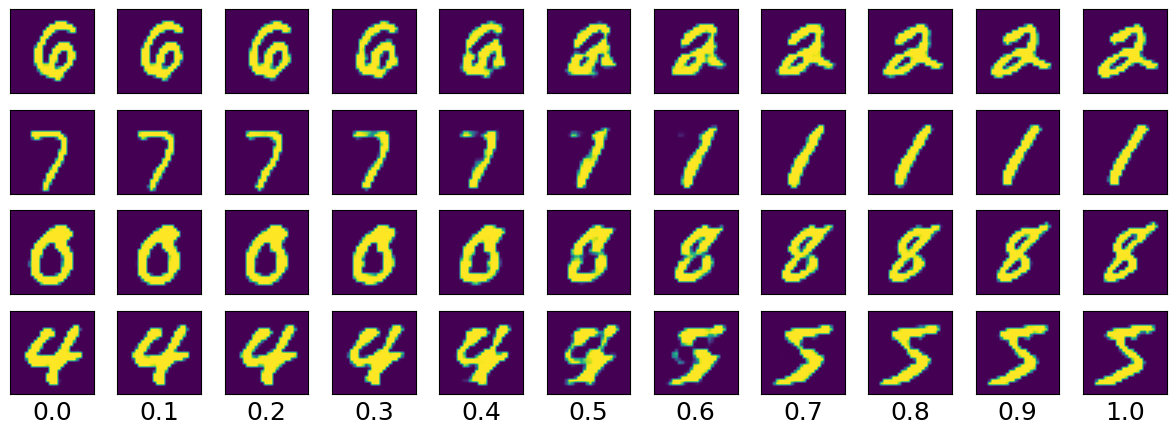

In [ ]:
fig, ax = plt.subplots(4, 11, figsize=(15, 5))

for i in range(11):
      x1, x2 = int(params_labels[2][0]), int(params_labels[6][500])
      z1, z2, interpolated = deep_conv_ae.interpolation(x1 = train_dataset_full.data[[x1]], x2 = train_dataset_full.data[[x2]], a = i/10)
      z1, z2, interpolated =  z1.flatten(), z2.flatten(), interpolated.flatten()
      ax[0, i].imshow(np.reshape(interpolated.cpu(), newshape=(28, 28)))
      ax[0, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

      x1, x2 = int(params_labels[1][0]), int(params_labels[7][200])
      z1, z2, interpolated = deep_conv_ae.interpolation(x1 = train_dataset_full.data[[x1]], x2 = train_dataset_full.data[[x2]], a = i/10)
      z1, z2, interpolated =  z1.flatten(), z2.flatten(), interpolated.flatten()
      ax[1, i].imshow(np.reshape(interpolated.cpu(), newshape=(28, 28)))
      ax[1, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

      x1, x2 = int(params_labels[8][15]), int(params_labels[0][200])
      z1, z2, interpolated = deep_conv_ae.interpolation(x1 = train_dataset_full.data[[x1]], x2 = train_dataset_full.data[[x2]], a = i/10)
      z1, z2, interpolated =  z1.flatten(), z2.flatten(), interpolated.flatten()
      ax[2, i].imshow(np.reshape(interpolated.cpu(), newshape=(28, 28)))
      ax[2, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

      x1, x2 = int(params_labels[5][0]), int(params_labels[4][500])
      z1, z2, interpolated = deep_conv_ae.interpolation(x1 = train_dataset_full.data[[x1]], x2 = train_dataset_full.data[[x2]], a = i/10)
      z1, z2, interpolated =  z1.flatten(), z2.flatten(), interpolated.flatten()
      ax[3, i].imshow(np.reshape(interpolated.cpu(), newshape=(28, 28)))
      ax[3, i].set_xlabel("{:.1f}".format(i/10), fontsize = 18)
      ax[3, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)




As previously mentioned, values between 0.1-0.3 and 0.7-0.9 ranges tend to put into high consideration the x1 or x2 they are associated with, and, in case of images belonging to different labels, there is a significat clear jump in terms of decoders' final results when traversing the critical 0.4-0.6 range.

Focusing on that range, we can observe more specifically how one reconstruction "morphs" into another one as the *a* parameter increases.

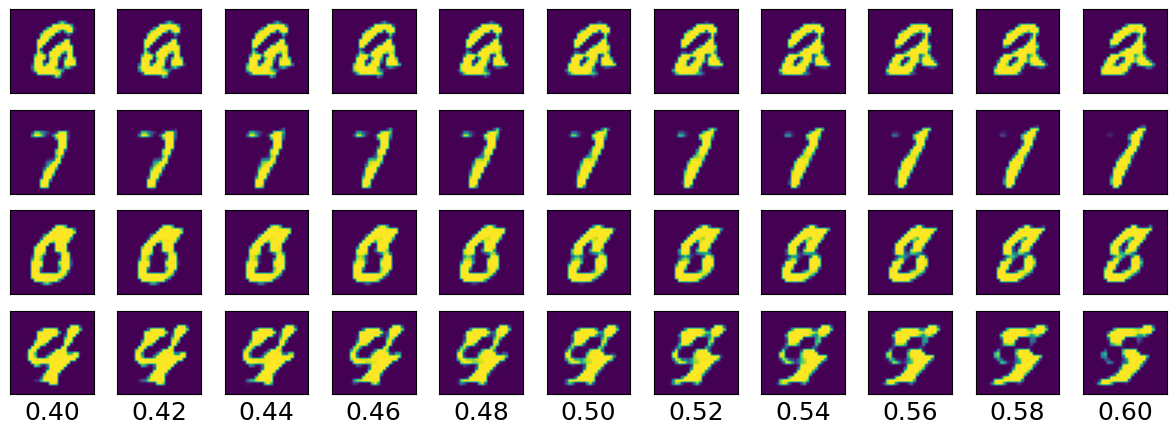

In [ ]:
fig, ax = plt.subplots(4, 11, figsize=(15, 5))
for i in range(0,21,2):
      k = int(i/2)

      x1, x2 = int(params_labels[2][0]), int(params_labels[6][500])
      z1, z2, interpolated = deep_conv_ae.interpolation(x1 = train_dataset_full.data[[x1]], x2 = train_dataset_full.data[[x2]], a = (4 + (i/10)) / 10)
      z1, z2, interpolated =  z1.flatten(), z2.flatten(), interpolated.flatten()
      ax[0, k].imshow(np.reshape(interpolated.cpu(), newshape=(28, 28)))
      ax[0, k].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

      x1, x2 = int(params_labels[1][0]), int(params_labels[7][200])
      z1, z2, interpolated = deep_conv_ae.interpolation(x1 = train_dataset_full.data[[x1]], x2 = train_dataset_full.data[[x2]], a = (4 + (i/10)) / 10)
      z1, z2, interpolated =  z1.flatten(), z2.flatten(), interpolated.flatten()
      ax[1, k].imshow(np.reshape(interpolated.cpu(), newshape=(28, 28)))
      ax[1, k].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

      x1, x2 = int(params_labels[8][15]), int(params_labels[0][200])
      z1, z2, interpolated = deep_conv_ae.interpolation(x1 = train_dataset_full.data[[x1]], x2 = train_dataset_full.data[[x2]], a = (4 + (i/10)) / 10)
      z1, z2, interpolated =  z1.flatten(), z2.flatten(), interpolated.flatten()
      ax[2, k].imshow(np.reshape(interpolated.cpu(), newshape=(28, 28)))
      ax[2, k].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


      x1, x2 = int(params_labels[5][0]), int(params_labels[4][500])
      z1, z2, interpolated = deep_conv_ae.interpolation(x1 = train_dataset_full.data[[x1]], x2 = train_dataset_full.data[[x2]], a = (4 + (i/10)) / 10)
      z1, z2, interpolated =  z1.flatten(), z2.flatten(), interpolated.flatten()

      ax[3, k].imshow(np.reshape(interpolated.cpu(), newshape=(28, 28)))
      ax[3, k].set_xlabel("{:.2f}".format((4 + (i/10)) / 10), fontsize = 18)
      ax[3, k].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)




A smoother transition considering larger gaps in terms of *a* can be observed when comparing images belonging to the same class: as it is shown below (and reasonable to guess, given the similarities of the images compared pair-wise), the "morphing" in this case is not strictly tied to a certain threshold but resembles more a continuous evolution from one figure to the other.

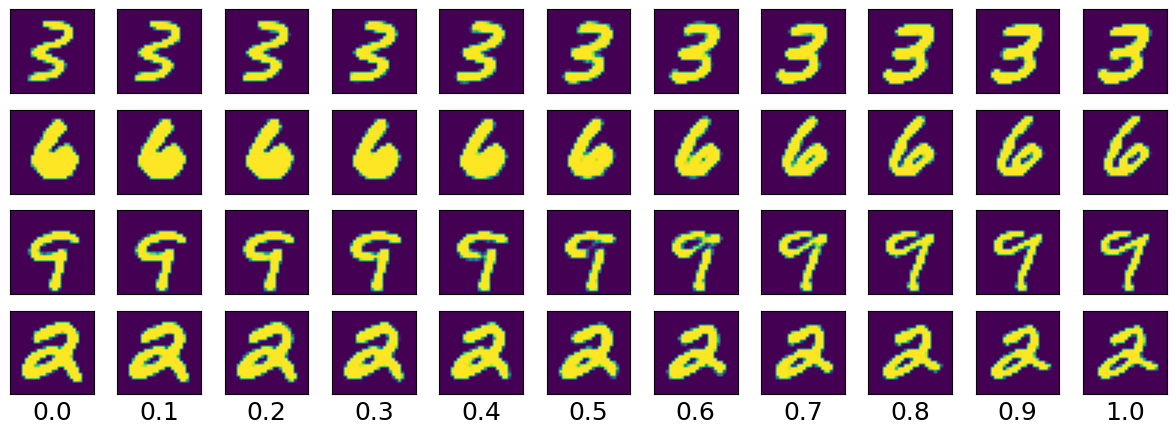

In [ ]:
fig, ax = plt.subplots(4, 11, figsize=(15, 5))

for i in range(11):
      x1, x2 = int(params_labels[3][0]), int(params_labels[3][500])
      z1, z2, interpolated = deep_conv_ae.interpolation(x1 = train_dataset_full.data[[x1]], x2 = train_dataset_full.data[[x2]], a = i/10)
      z1, z2, interpolated =  z1.flatten(), z2.flatten(), interpolated.flatten()
      ax[0, i].imshow(np.reshape(interpolated.cpu(), newshape=(28, 28)))
      ax[0, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

      x1, x2 = int(params_labels[6][0]), int(params_labels[6][200])
      z1, z2, interpolated = deep_conv_ae.interpolation(x1 = train_dataset_full.data[[x1]], x2 = train_dataset_full.data[[x2]], a = i/10)
      z1, z2, interpolated =  z1.flatten(), z2.flatten(), interpolated.flatten()
      ax[1, i].imshow(np.reshape(interpolated.cpu(), newshape=(28, 28)))
      ax[1, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

      x1, x2 = int(params_labels[9][15]), int(params_labels[9][200])
      z1, z2, interpolated = deep_conv_ae.interpolation(x1 = train_dataset_full.data[[x1]], x2 = train_dataset_full.data[[x2]], a = i/10)
      z1, z2, interpolated =  z1.flatten(), z2.flatten(), interpolated.flatten()
      ax[2, i].imshow(np.reshape(interpolated.cpu(), newshape=(28, 28)))
      ax[2, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

      x1, x2 = int(params_labels[2][0]), int(params_labels[2][500])
      z1, z2, interpolated = deep_conv_ae.interpolation(x1 = train_dataset_full.data[[x1]], x2 = train_dataset_full.data[[x2]], a = i/10)
      z1, z2, interpolated =  z1.flatten(), z2.flatten(), interpolated.flatten()
      ax[3, i].imshow(np.reshape(interpolated.cpu(), newshape=(28, 28)))
      ax[3, i].set_xlabel("{:.1f}".format(i/10), fontsize = 18)
      ax[3, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)




#### Data visualization

As an additional usage from the encoding of the original input data-set using an autoencoder, given the data representation in the latent space, we can also perform dimensionality reduction techniques for data visualization purposes using the embeddings resulting from such process.

Here we visualize t-SNE results applied on the embedding respectively from a  denoising deep convolutional autoencoder and a deep linear one.

A slightly more precise distinction is observable in the convolutional scenario, even if t-SNE seems capable of separating the different digits with not major issues.

In [ ]:
import seaborn as sns
from sklearn.manifold import TSNE

def tsne_visualization(model, data_set, title, components = 2):
  with torch.no_grad():
        model.cpu()
        encoding_representation = torch.flatten(model.encoder(data_set.data.cpu()), 1)
        embedded_representation = TSNE(n_components=components, verbose=1).fit_transform(encoding_representation)

  plt.figure(figsize=(10, 8))
  sns.scatterplot(x=embedded_representation[:, 0], y=embedded_representation[:, 1],
                    hue=data_set.classes.cpu(),
                    legend="full",
                    palette=sns.color_palette("hls", 10))

  plt.tight_layout()
  plt.axis('off')
  plt.title(title)
  plt.show()


In [ ]:
deep_conv_ae = ConvolutionalDeepAutoencoder(layers_dimensions = [5,10], kernels = [3,5], img_size = (28,28), final_linear_dimension = 200, pooling=False)
deep_conv_ae.fit(train_set = X_train, val_set = X_val_early_stopping, epochs = 20, lr = 0.1, momentum = 0.0, batch_size = 16, early_stopping = True)

deep_linear = LinearDeepAutoencoder(layers_dimensions = [784,500,400])
deep_linear.pre_train_layers(train_set = X_train, val_set = X_val_early_stopping, epochs = 20, lr = 0.1, momentum = 0.1, batch_size = 16, early_stopping = True)
deep_linear.fit(train_set = X_train, val_set = X_val_early_stopping, epochs = 500, lr = 0.3, momentum = 0.2, batch_size = 16, early_stopping = True)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 3.089s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 22.681691
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.359261
[t-SNE] KL divergence after 1000 iterations: 1.861982


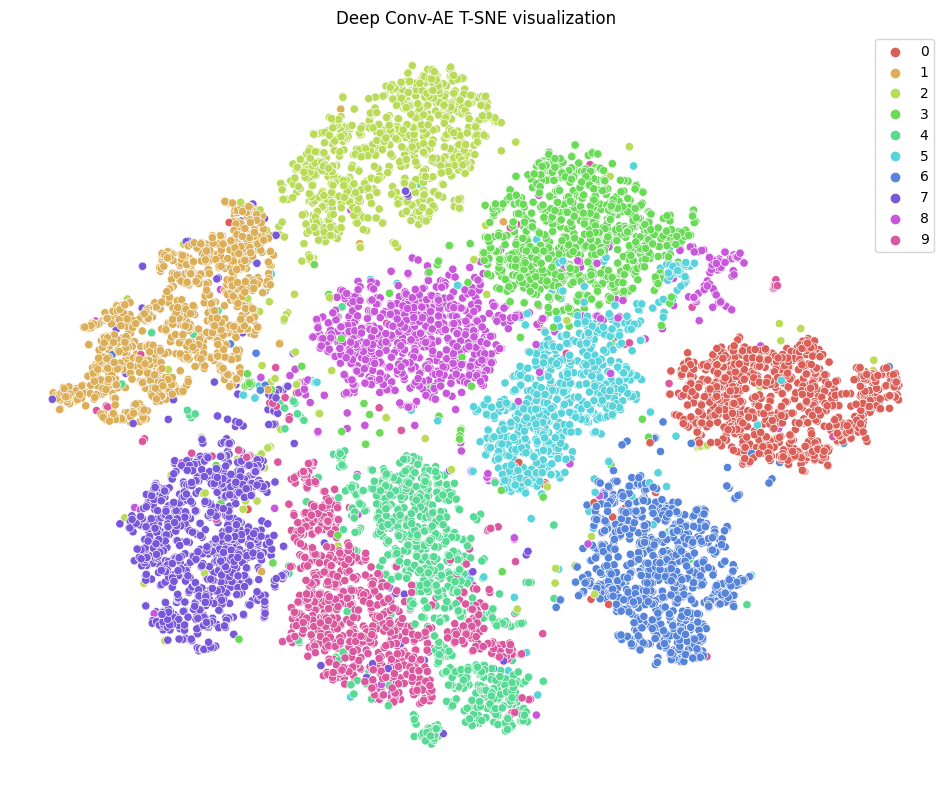

In [ ]:
tsne_visualization(deep_conv_ae, test_dataset, title = 'Deep Conv-AE T-SNE visualization')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 3.038s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 29.679640
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.726196
[t-SNE] KL divergence after 1000 iterations: 1.791004


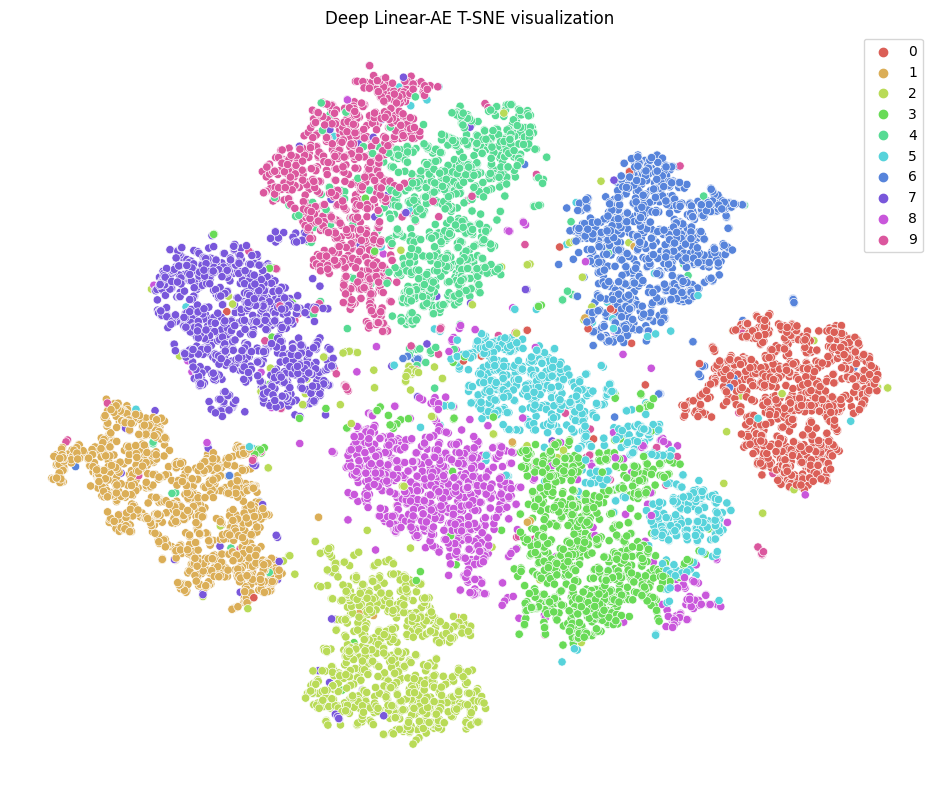

In [ ]:
tsne_visualization(deep_linear, test_dataset, title = 'Deep Linear-AE T-SNE visualization')

## Section 3 - Brief comments and conclusions

We trained and compared 2 different kinds of autoencoder (linear and convolutionla ones), in their simple one layer form and a respective deep version. Convolutional architectures resulted to be the most accurate in terms of image reconstruction and accuracy on evaluated by a classifier on top of the encodings.

We also performed a linear interpolation in the latent space starting from encoding of images belonging to the same classes and different ones, noticing how for images belonging to the same digit label, the decoding "transitions" is smoother when traversing the *a* parameter values.

A final visualization is also presented using t-SNE as dimensionality reduction method for visualization purposes: results in this case are satisfactory, also due to the simple structure of the MNIST data-set.

As an expansion for future work, different approach to produce noisy instances could be used, along with more sophisticated architecture and different kinds of pooling for the convolutional structure.

